1. Взять ожидания аналитиков, что будет в будущем и на этом основании прогнозировать <br>
2. Использовать Дамми если есть шок, которые не связан с экзогенными переменными <br>
3. Данные по компании (производственные мощности) - прогнозирование <br>
4. Что-то не так с прогнозами? Или это проблема в том, что данные плохо прогнозируются этими моделями? Смотрет предикшн в конце <br>
5. Коинтеграция с ценой на никель <br>



1. Try dumped trend in ETS - забей
2. Describe ETS +-
3. Try seasonality in ARIMA and describe it
4. Gather MAPE from all models +
5. Provide estimated coefficients - только на финальную, лучшую модель

__Intro__ <br>
The report aims to provide an examination of the Nickel Industries Ltd (ASX: NIC) stock performance utilizing basic time-series models.

In [1]:
import time
from datetime import datetime

# Data import, transformation
import pandas as pd
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sktime.utils.plotting import plot_series, plot_correlations

# Tools
from sktime.forecasting.model_selection import ExpandingWindowSplitter, ForecastingGridSearchCV
from statsmodels.tsa.stattools import adfuller, kpss

# ETS, STL
import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from sktime.forecasting.ets import AutoETS

# ARIMA
from statsmodels.tsa.arima.model import ARIMA


#Metrics
from sklearn.metrics import mean_squared_error
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

# warnings
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning, ValueWarning
warnings.simplefilter('ignore')

In [2]:
fx_rates = pd.read_csv('fx_rates.csv')
fx_rates['Date'] = pd.to_datetime(fx_rates['Date'].astype(str).str[0:10])
#fx_rates['Date'] = [pd.Timestamp(t, tz='Australia/Sydney') for t in fx_rates['Date']]
fx_rates = fx_rates.set_index('Date')

df = pd.read_csv('nickel_industries_ts_data.csv')
df['Date'] = pd.to_datetime(df['Date'].astype(str).str[0:10])
#df['Date'] = [pd.Timestamp(t, tz='Australia/Sydney') for t in df['Date']]
df = df.set_index('Date')

df.drop(columns='Stock Splits', inplace=True)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 54 entries, 2018-09-30 to 2023-02-28
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Close                         54 non-null     float64
 1   Volume                        54 non-null     int64  
 2   Dividends                     54 non-null     float64
 3   Ni_price                      54 non-null     float64
 4   aus_int_rate                  54 non-null     float64
 5   Base_metal_products_vol       52 non-null     float64
 6   Nickel_ore_vol                52 non-null     object 
 7   Base_metal_products_val_mil$  53 non-null     float64
 8   Nickel_ore_val_mil$           53 non-null     object 
 9   Export_to_China_mil$          53 non-null     float64
dtypes: float64(7), int64(1), object(2)
memory usage: 4.6+ KB


__Nickel Industries Description__ <br>
Nickel Industries Ltd (ASX: NIC) is an Australian-based mining and exploration company that focuses on the production of nickel pig iron and other nickel products. The company operates in Indonesia and has a portfolio of assets that includes several large-scale nickel mines and processing facilities. <br>
Nickel Industries Ltd's flagship asset is the Hengjaya nickel mine, which is located in the Morowali Regency of Central Sulawesi in Indonesia. The mine is operated by PT Hengjaya Mineralindo, which is a joint venture between Nickel Industries Ltd and China's Tsingshan Group. The mine produces nickel pig iron, which is a key component in the production of stainless steel. <br>
Nickel Industries Ltd also has a 60% interest in the Ranger Nickel Project, which is a large-scale nickel laterite deposit located in Indonesia's Sulawesi province. The company has plans to develop the project into a major nickel operation. <br>


# SPLITS

In [4]:
endog = df['Close'].rename(index='Nickel_Industries_Stock_Price')

exog = df[['Ni_price', 'aus_int_rate', 'Base_metal_products_vol']]

In [5]:
# Specify cut-off dates
cut_off = '2022-08-31' # where the train set ends
cut_off_test = '2022-09-30' # where the test set starts

In [6]:
# prices without any transformations for STL Decomposition and ETS Models
endog_train_p = endog.loc[:cut_off]
endog_test_p = endog.loc[cut_off_test:]
#reindexing datetime for ETS from sktime
endog_train_ind = endog_train_p.reindex(pd.date_range(start=endog_train_p.index[0], end=endog_train_p.index[-1], freq='M'))

# transformed variables used in ARIMA models
#endog_all = endog.div(endog.shift()).dropna()
endog_all = endog.diff().dropna()

endog_train = endog_all.loc[:cut_off]
endog_test = endog_all.loc[cut_off_test:]

# exogenous variables
exog_train = exog.loc[:cut_off]
exog_test = exog.loc[cut_off_test:]

final_performance_cols = ['Is_y_transformed?', 'Model', 'Train_MAPE', 'Test_MAPE', 'Train_RMSE', 'Test_RMSE']
model_performance = pd.DataFrame(columns=final_performance_cols)

horizon = list(range(1, 7))

# Grapical analysis

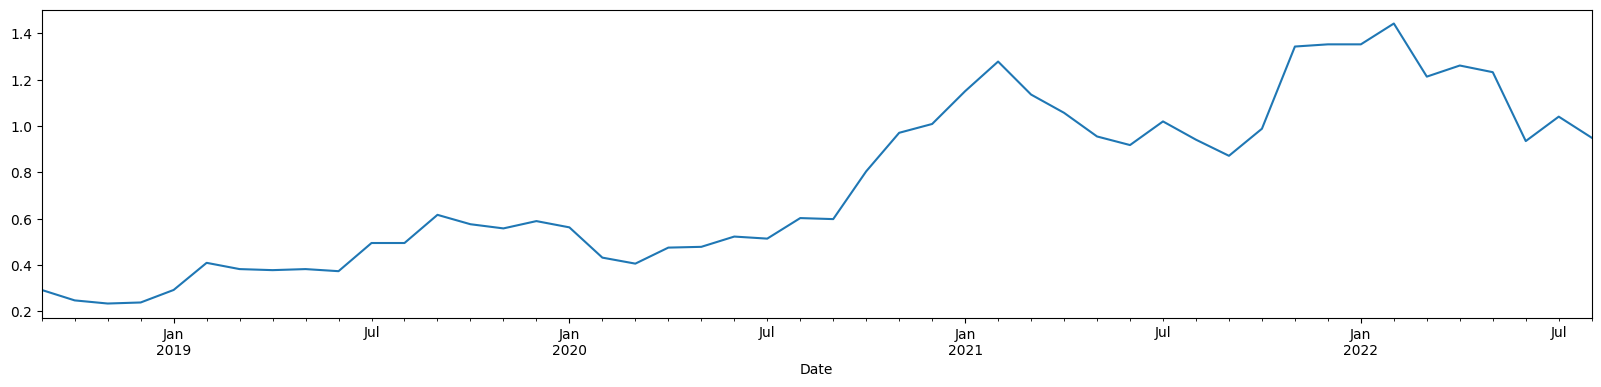

In [7]:
endog_train_p.plot(figsize=(20,4));

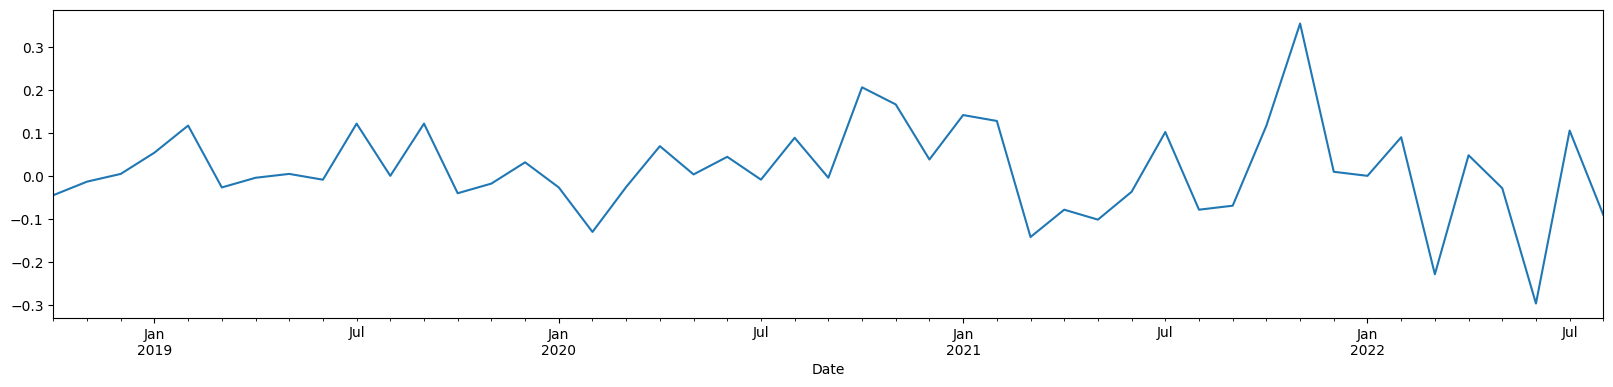

In [8]:
endog_train_p.diff().dropna().plot(figsize=(20,4));

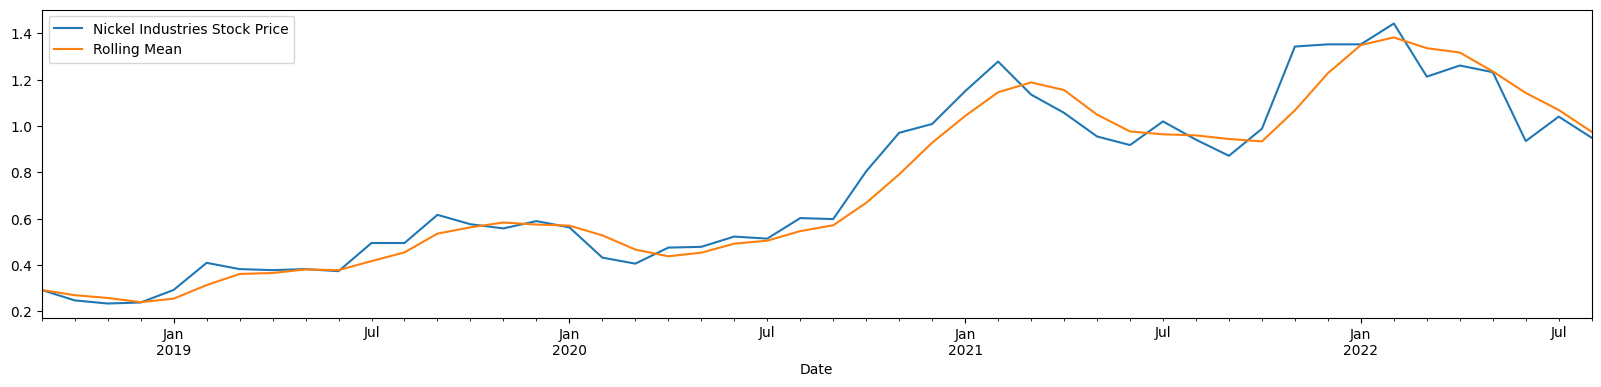

In [9]:
# Rolling window functions
rolling_price = endog_train_p.rolling('90D').mean()

endog_train_p.plot()
rolling_price.plot(figsize=(20,4))
plt.legend(['Nickel Industries Stock Price','Rolling Mean'])
# Plotting a rolling mean of 90 day window with original Close attribute of Nickel Industries stocks
plt.show()

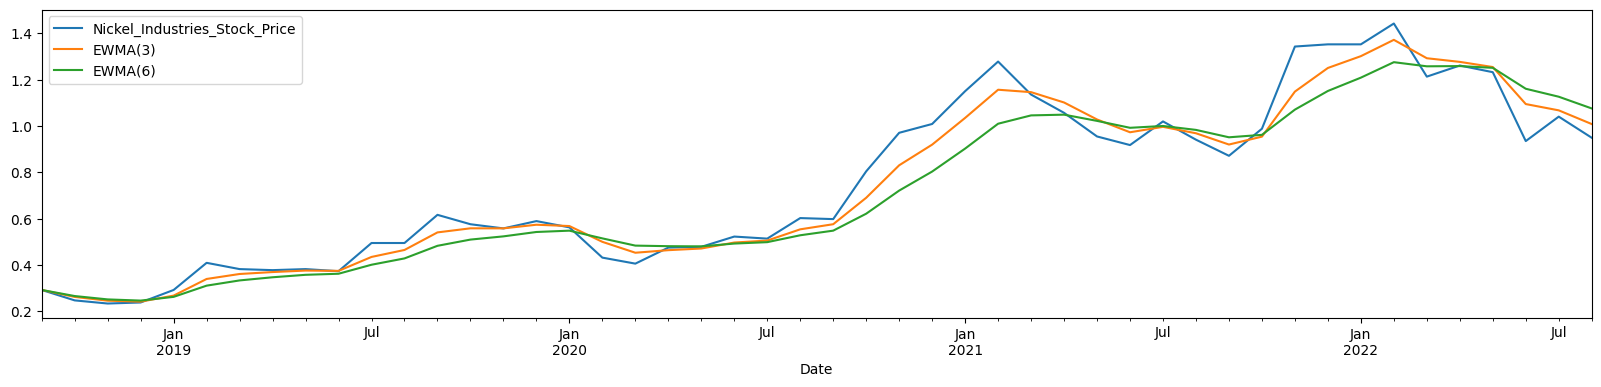

In [10]:
column = 'Nickel_Industries_Stock_Price'
ewma = pd.DataFrame(endog_train_p)
for span in [3, 6]:
    ewma['EWMA(' + str(span) + ')'] = ewma[column].ewm(span=span).mean()
ewma.plot(figsize=(20, 4))
plt.show()

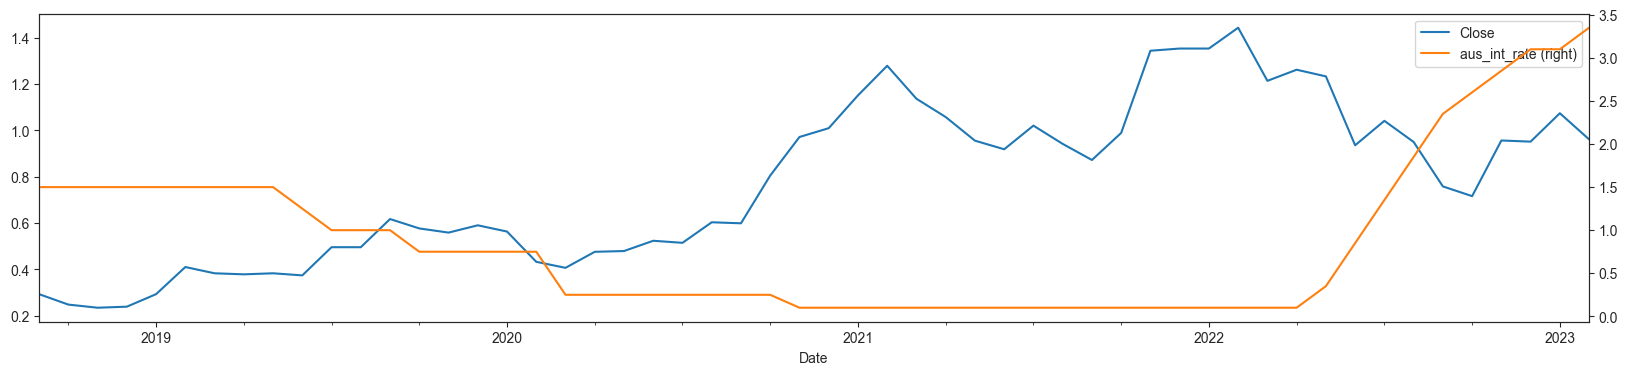

In [11]:
with sns.axes_style('white'):
    sns.set_style('ticks')
    df[['Close', 'aus_int_rate']].plot(figsize=(20, 4), secondary_y=['aus_int_rate'])
    plt.show()

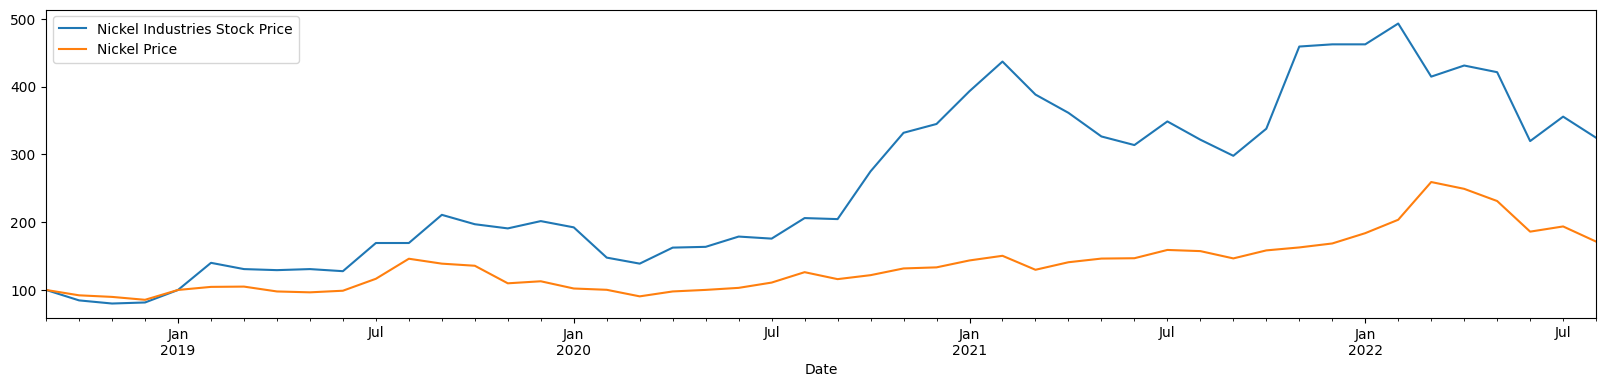

In [12]:
# Normalizing and comparison
# Both series start from 100
ni_price = pd.DataFrame(exog['Ni_price'].loc[:'2022-08-31'])
normalized_price = endog_train_p.div(endog_train_p.iloc[0]).mul(100)
normalized_ni = ni_price.Ni_price.div(ni_price.Ni_price.iloc[0]).mul(100)
normalized_price.plot(figsize=(20,4))
normalized_ni.plot(figsize=(20,4))
plt.legend(['Nickel Industries Stock Price','Nickel Price'])
plt.show()

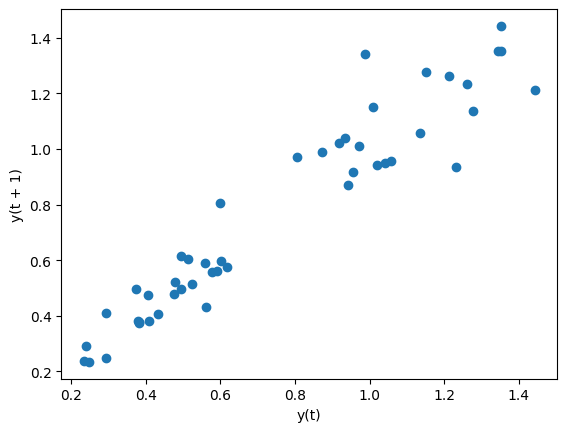

In [13]:
pd.plotting.lag_plot(endog_train_p, lag=1);

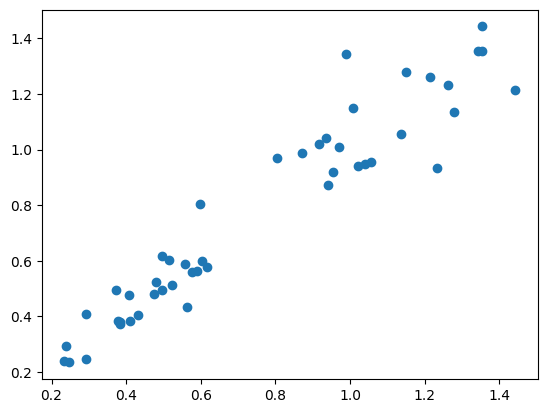

In [14]:
a = endog_train_p.shift().dropna()
b = endog_train_p.loc['2018-10-31':]
plt.scatter(x=a, y=b)
plt.show()

# STL Decomposition

STL decomposition is a time-series decomposition method that involves separating a time-series into three components: trend, seasonal, and residual.

Given a time-series data vector $ y $ with length $ n $, STL decomposition seeks to decompose it into three components: <br>
$ y = T + S + R $<br>
where <br>
$ T $ is the trend component, $ S $ is the seasonal component, $ R $ is the remainder (residual) component.<br>

The STL decomposition process involves iteratively smoothing the data to obtain the trend and seasonal components, while also updating the residual component. The smoothing parameters used in the decomposition process are determined by minimizing the sum of the squared residuals between the original data and the estimated trend, seasonal, and residual components.

STL Decomposition of Nickel Industries Ltd is presented below:

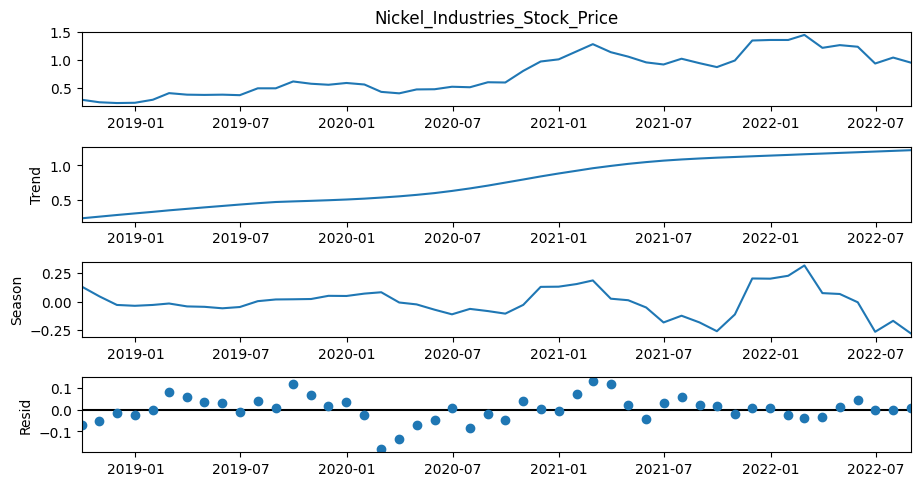

In [15]:
stl_decomp_mod_p = STL(endog_train_p)
stl_decomp_res_p = stl_decomp_mod_p.fit()
figure_2 = stl_decomp_res_p.plot()

figure_2.set_figwidth(10)
figure_2.set_figheight(5)

#plt.title('Nickel Industries Stock Price Decomposition')
#plt.savefig('NIC_STL_Decomposition', dpi=300)
plt.show()

__Trend__ <br>
We can observe ascending trend which can be explained by a number of factors. 
In our opinion most influatial factors are the following:  <br>
1. Commissioning of new production facilities <br>
2. Tax reliefs from Indoneaisan government during analyzed period <br>
3. Increased growth expectation of whole Nickel industry <br>

__Seasonality__ <br>
We do not clearly observe seasonality pattern, but still going to consider different cases, especially the quarterly seasonality, due to company's reports timing.

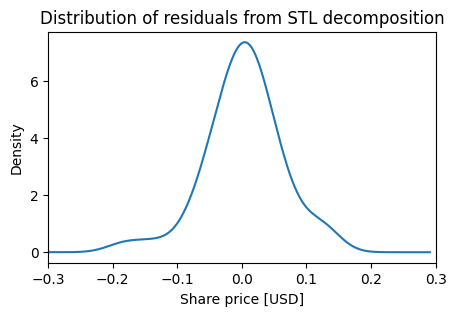

In [16]:
stl_decomp_res_p.resid.plot(kind='kde', figsize=(5, 3))
plt.xlim([-0.3, 0.3])
#figure_2.set_figwidth(10)
#figure_2.set_figheight(5)
plt.title('Distribution of residuals from STL decomposition')
plt.xlabel("Share price [USD]")
#plt.savefig('NIC_STL_Resid_Distribution', bbox_inches = 'tight', dpi=100)
plt.show()

# ETS

ETS (Error, Trend, Seasonality) is a family of time-series models that can be used to forecast future values based on historical data. <br>
The basic idea behind ETS models is to decompose a time-series into three components: Error (E), Trend (T), and Seasonality (S). <br>
The error component represents the random fluctuations or noise in the data that cannot be explained by the trend or seasonality. The trend component represents the long-term direction or pattern in the data, and the seasonality component represents the periodic fluctuations in the data. <br>

The ETS(A,A,A) model assumes that the time-series has an additive error component, an additive trend, and an additive seasonal component. The model can be written as: <br>
$ \large{y_t = l_{t-1} + b_{t-1} + s_{t-m} + e_t} $ <br>
where $ y_t $ is the observed value at time t, <br>
$ \large{e_t} $ is the error term at time t, <br>
$ \large{l_{t-1}} $ is the level at time t-1, <br>
$ \large{b_{t-1}} $ is the slope at time t-1 <br>
$ \large{s_{t-m}} $ is the seasonal component at time t-m (m is the seasonal period) <br>
In our case we chosen seasonal component m = 4, in order to reflect on issuence of company's quarterly reports.

## ETS (AAA)

In [17]:
ETS_AAA_model = ETSModel(endog_train_p, 
                          error = 'add', 
                          trend = 'add', 
                          seasonal = 'add', 
                          seasonal_periods=4,
                          damped_trend=False,
                          freq='M')
ETS_AAA_res = ETS_AAA_model.fit()
ETS_AAA_pred = ETS_AAA_res.predict()
ETS_AAA_fork = ETS_AAA_res.forecast(len(horizon))
#mean_absolute_percentage_error(endog_test, ETS_best_res.forecast(len(horizon))).round(5)


In [18]:
Model_1 = pd.Series({
    final_performance_cols[0]: 'No',
    final_performance_cols[1]: 'ETS(AAA)',
    final_performance_cols[2]: mean_absolute_percentage_error(endog_train_p, ETS_AAA_pred).round(6),
    final_performance_cols[3]: mean_absolute_percentage_error(endog_test_p, ETS_AAA_fork).round(6),
    final_performance_cols[4]: mean_squared_error(endog_train_p, ETS_AAA_pred, squared=False).round(6),
    final_performance_cols[5]: mean_squared_error(endog_test_p, ETS_AAA_fork, squared=False).round(6)
}).to_frame().T

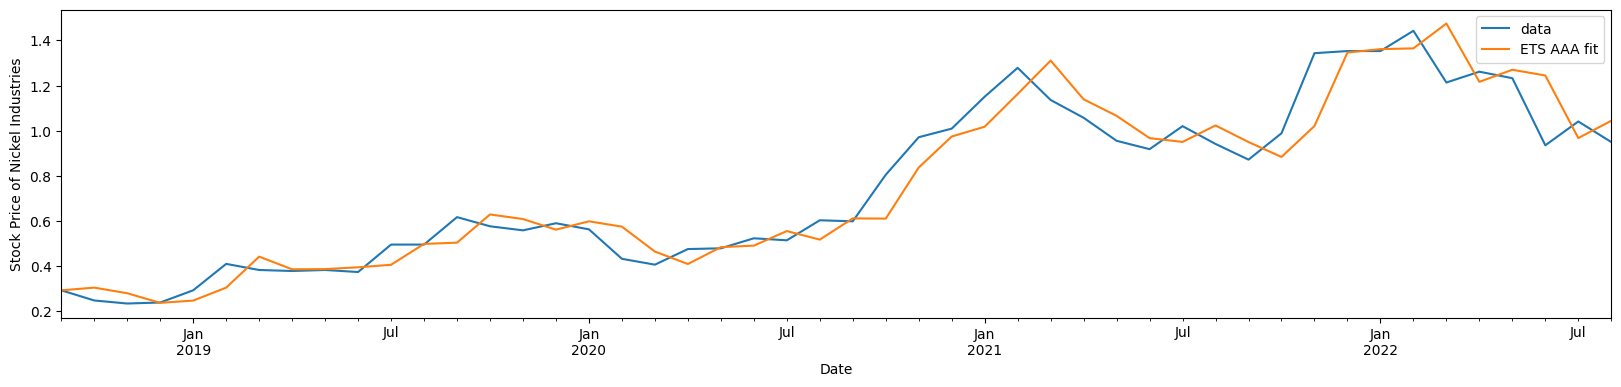

In [19]:
endog_train_p.plot(label="data", figsize=(20, 4))
ETS_AAA_res.fittedvalues.plot(label="ETS AAA fit")
plt.ylabel("Stock Price of Nickel Industries")
plt.legend();

In [20]:
print(Model_1)
ETS_AAA_res.summary()

  Is_y_transformed?     Model Train_MAPE Test_MAPE Train_RMSE Test_RMSE
0                No  ETS(AAA)   0.106932   0.14133    0.10701  0.140038


<class 'statsmodels.iolib.summary.Summary'>
"""
                                       ETS Results                                       
=========================================================================================
Dep. Variable:     Nickel_Industries_Stock_Price   No. Observations:                   48
Model:                                  ETS(AAA)   Log Likelihood                  39.163
Date:                           Sun, 26 Mar 2023   AIC                            -58.326
Time:                                   19:41:09   BIC                            -39.614
Sample:                               09-30-2018   HQIC                           -51.255
                                    - 08-31-2022   Scale                            0.011
Covariance Type:                          approx                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
smoothing_level        0.9999        nan        nan        nan         nan         nan
smoothing_trend     9.999e-05        nan        nan        nan         nan         nan
smoothing_seasonal  2.455e-06        nan        nan        nan         nan         nan
initial_level          0.2789        nan        nan        nan         nan         nan
initial_trend          0.0139      0.016      0.886      0.376      -0.017       0.045
initial_seasonal.0     0.0054        nan        nan        nan         nan         nan
initial_seasonal.1     0.0162        nan        nan        nan         nan         nan
initial_seasonal.2    -0.0020        nan        nan        nan         nan         nan
initial_seasonal.3          0        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (Q):                       15.13   Jarque-Bera (JB):                 5.60
Prob(Q):                              0.06   Prob(JB):                         0.06
Heteroskedasticity (H):               6.79   Skew:                            -0.11
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

The ETS(MAN) model assumes that the time-series has an multiplicative error component, an additive trend, and absence of seasonal component. The model can be written as: <br>

Level equation: L_t = α(Y_t / S_{t-m}) + (1-α)(L_{t-1} + T_{t-1}) <br>
Trend equation: T_t = β(L_t - L_{t-1}) + (1-β)T_{t-1} <br>
Seasonal equation: S_t = γ(Y_t / L_t) + (1-γ)S_{t-m} <br>
where:
L_t = level component at time t <br>
T_t = trend component at time t <br>
S_t = seasonal component at time t <br>
Y_t = actual value of the time series at time t m = the number of seasons in a year <br>
α = smoothing parameter for level component <br>
β = smoothing parameter for trend component <br>
γ = smoothing parameter for seasonal component <br>
The forecast for the next time period (t+1) is then given by: <br>
Ŷ_{t+1} = (L_t + T_t) × S_{t+1-m} <br>



# ETS (MAN)

In [21]:
ETS_MAN_model = ETSModel(endog_train_p, 
                          error = 'mul', 
                          trend = 'add', 
                          seasonal = None, 
                          seasonal_periods=4,
                          damped_trend=False,
                          freq='M')
ETS_MAN_res = ETS_MAN_model.fit()
ETS_MAN_pred = ETS_MAN_res.predict()
ETS_MAN_fork = ETS_MAN_res.forecast(len(horizon))

In [22]:
Model_2 = pd.Series({
    final_performance_cols[0]: 'No',
    final_performance_cols[1]: 'ETS(MAN)',
    final_performance_cols[2]: mean_absolute_percentage_error(endog_train_p, ETS_MAN_pred).round(6),
    final_performance_cols[3]: mean_absolute_percentage_error(endog_test_p, ETS_MAN_fork).round(6),
    final_performance_cols[4]: mean_squared_error(endog_train_p, ETS_MAN_pred, squared=False).round(6),
    final_performance_cols[5]: mean_squared_error(endog_test_p, ETS_MAN_fork, squared=False).round(6)
}).to_frame().T

In [23]:
print(Model_2)
ETS_MAN_res.summary()

  Is_y_transformed?     Model Train_MAPE Test_MAPE Train_RMSE Test_RMSE
0                No  ETS(MAN)   0.110489  0.163309    0.10797   0.16028


<class 'statsmodels.iolib.summary.Summary'>
"""
                                       ETS Results                                       
=========================================================================================
Dep. Variable:     Nickel_Industries_Stock_Price   No. Observations:                   48
Model:                                  ETS(MAN)   Log Likelihood                  46.624
Date:                           Sun, 26 Mar 2023   AIC                            -83.247
Time:                                   19:41:10   BIC                            -73.891
Sample:                               09-30-2018   HQIC                           -79.711
                                    - 08-31-2022   Scale                            0.018
Covariance Type:                          approx                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
smoothing_level     0.9999      0.149      6.695      0.000       0.707       1.293
smoothing_trend  9.999e-05        nan        nan        nan         nan         nan
initial_level       0.2642      0.039      6.758      0.000       0.188       0.341
initial_trend       0.0234      0.006      3.819      0.000       0.011       0.035
===================================================================================
Ljung-Box (Q):                        0.22   Jarque-Bera (JB):                 2.72
Prob(Q):                              0.89   Prob(JB):                         0.26
Heteroskedasticity (H):               0.89   Skew:                             0.58
Prob(H) (two-sided):                  0.81   Kurtosis:                         3.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

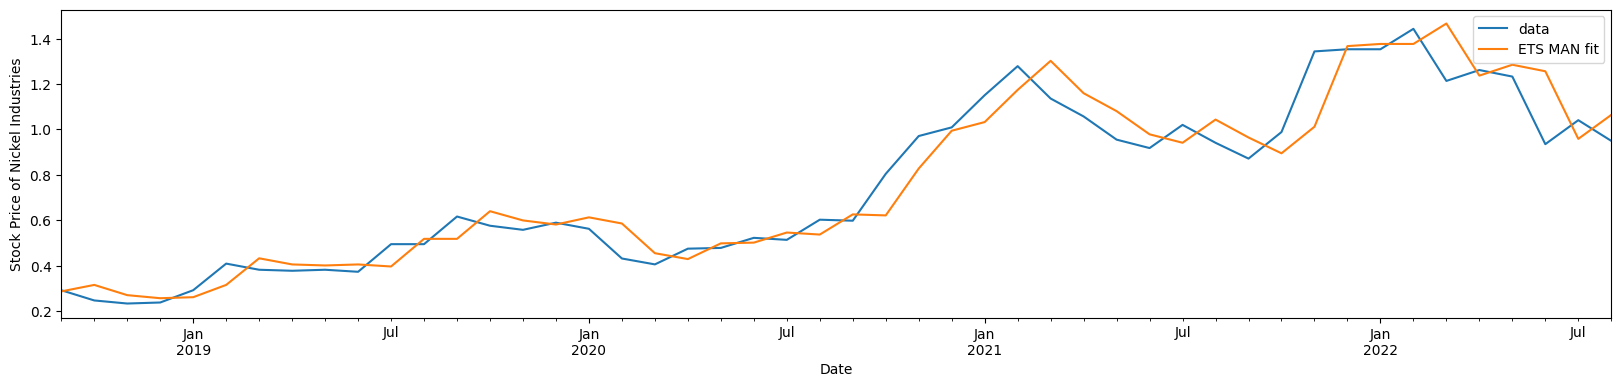

In [24]:
endog_train_p.plot(label="data", figsize=(20, 4))
ETS_MAN_res.fittedvalues.plot(label="ETS MAN fit")
plt.ylabel("Stock Price of Nickel Industries")
plt.legend();

Now we will try to use grid search in order to choose the best performing ETS model.

## ETS auto (MNA)

In [25]:
ets_model = AutoETS(sp=4) # quarterly seasonality assumed? 
grid = {'error': ['add', 'mul'], 'trend': ['add', 'mul', None], 'seasonal': ['add', 'mul', None]}

cv_params = ExpandingWindowSplitter(initial_window=len(endog_train_p)-len(horizon), fh=horizon, step_length=1)

ets_cv = ForecastingGridSearchCV(forecaster=ets_model, cv=cv_params, 
                                 param_grid=grid, error_score='raise')

In [26]:
ETS_auto_res = ets_cv.fit(endog_train_ind)
ETS_auto_res.best_params_

{'error': 'mul', 'seasonal': 'add', 'trend': None}

In [27]:
ETS_auto_model = ETSModel(endog_train_p, 
                          error=ETS_auto_res.best_params_['error'], 
                          trend=ETS_auto_res.best_params_['trend'], 
                          seasonal=ETS_auto_res.best_params_['seasonal'], 
                          seasonal_periods=4, 
                          freq='M')
ETS_best_res = ETS_auto_model.fit()
ETS_best_pred = ETS_best_res.predict()
ETS_best_fork = ETS_best_res.forecast(len(horizon))

In [28]:
Model_3 = pd.Series({
    final_performance_cols[0]: 'No',
    final_performance_cols[1]: 'ETS(MNA)_auto',
    final_performance_cols[2]: mean_absolute_percentage_error(endog_train_p, ETS_MAN_pred).round(6),
    final_performance_cols[3]: mean_absolute_percentage_error(endog_test_p, ETS_best_fork).round(6),
    final_performance_cols[4]: mean_squared_error(endog_train_p, ETS_MAN_pred, squared=False).round(6),
    final_performance_cols[5]: mean_squared_error(endog_test_p, ETS_best_fork, squared=False).round(6)
}).to_frame().T

In [29]:
print(Model_3)
ETS_best_res.summary()

  Is_y_transformed?          Model Train_MAPE Test_MAPE Train_RMSE Test_RMSE
0                No  ETS(MNA)_auto   0.110489  0.120047    0.10797  0.137343


<class 'statsmodels.iolib.summary.Summary'>
"""
                                       ETS Results                                       
=========================================================================================
Dep. Variable:     Nickel_Industries_Stock_Price   No. Observations:                   48
Model:                                  ETS(MNA)   Log Likelihood                  44.462
Date:                           Sun, 26 Mar 2023   AIC                            -72.925
Time:                                   19:41:13   BIC                            -57.955
Sample:                               09-30-2018   HQIC                           -67.268
                                    - 08-31-2022   Scale                            0.022
Covariance Type:                          approx                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
smoothing_level        0.9999        nan        nan        nan         nan         nan
smoothing_seasonal    2.4e-05        nan        nan        nan         nan         nan
initial_level          0.2867   1491.517      0.000      1.000   -2923.033    2923.606
initial_seasonal.0    -0.0033   1491.516  -2.21e-06      1.000   -2923.321    2923.315
initial_seasonal.1     0.0072   1491.518   4.84e-06      1.000   -2923.314    2923.328
initial_seasonal.2     0.0087   1491.519   5.85e-06      1.000   -2923.315    2923.333
initial_seasonal.3          0   1491.517          0      1.000   -2923.319    2923.319
===================================================================================
Ljung-Box (Q):                        5.30   Jarque-Bera (JB):                 2.15
Prob(Q):                              0.73   Prob(JB):                         0.34
Heteroskedasticity (H):               0.88   Skew:                             0.52
Prob(H) (two-sided):                  0.79   Kurtosis:                         3.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

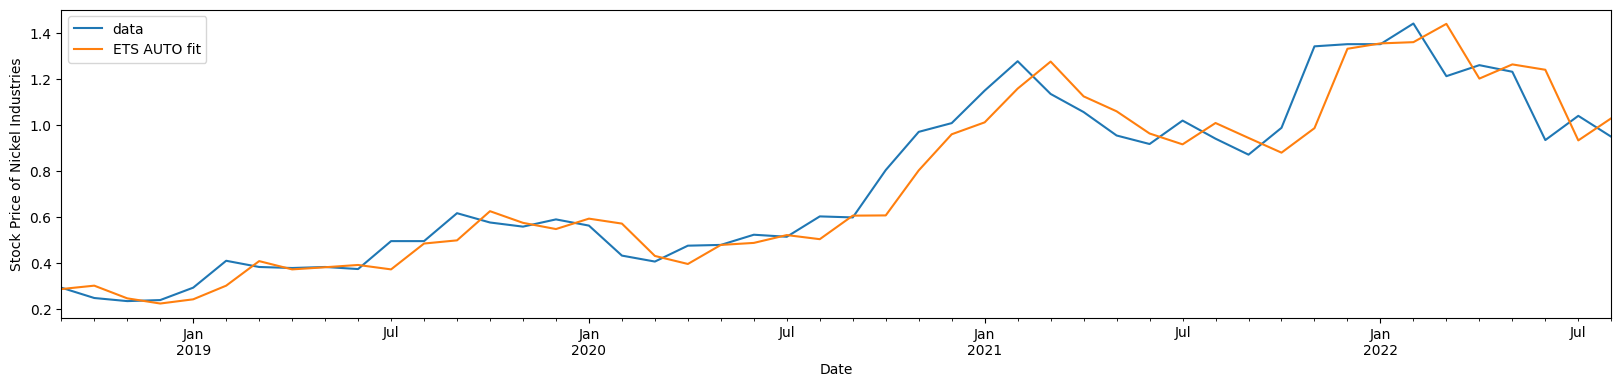

In [30]:
endog_train_p.plot(label="data", figsize=(20, 4))
ETS_best_res.fittedvalues.plot(label="ETS AUTO fit")
plt.ylabel("Stock Price of Nickel Industries")
plt.legend();

### Stationarity check before applying ARIMA

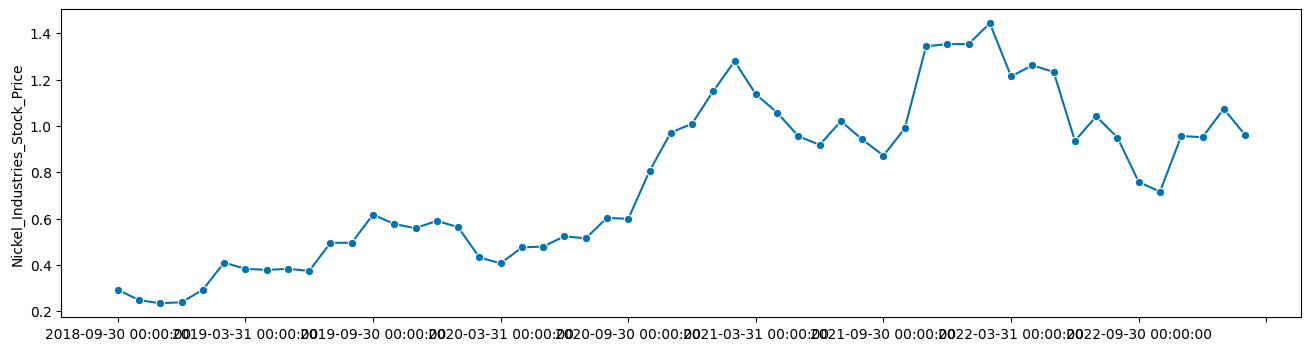

In [31]:
plot_series(endog);

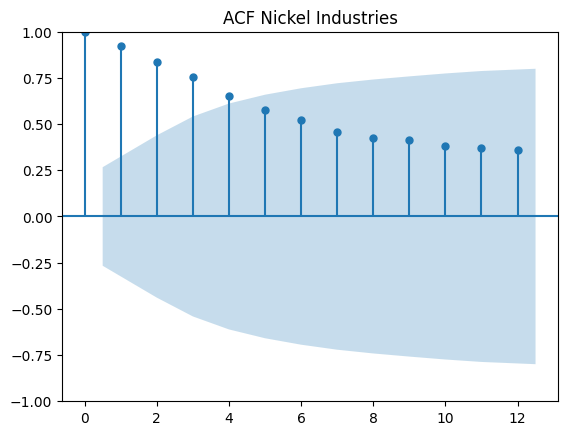

In [32]:
# Autocorrelation of stock price of Nickel Industries
plot_acf(endog, lags=12, title="ACF Nickel Industries")
plt.show()

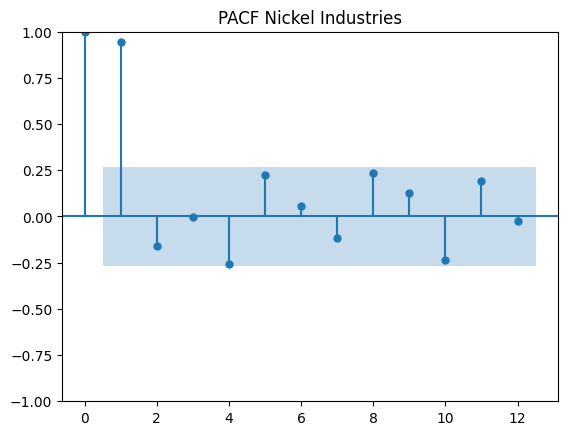

In [33]:
# Partial autocorrelation of stock price of Nickel Industries
plot_pacf(endog, lags=12, title="PACF Nickel Industries")
plt.show()

#### Augmented Dickey-Fuller test (ADF)

H0: β = 0 (This is a random walk) <br>
H1: β < 0 (This is not a random walk)

In [34]:
# Augmented Dickey-Fuller test on price
adf_price = adfuller(endog_train_p)
print("p-value of ADF: {}".format(float(adf_price[1].round(4))))

p-value of ADF: 0.5942


#### KPSS test

H0: Stationary <br>
H1: Not Stationary

In [35]:
# KPSS test for stationarity
kpss_test = kpss(endog_train_p)
print("p-value of KPSS: {}".format(float(kpss_test[1].round(4))))

p-value of KPSS: 0.01


Stationarity is an important concept in time series analysis because it ensures that the statistical properties of the data remain constant over time. In other words, if a time series is stationary, its mean, variance, and autocorrelation structure do not change over time. <br>
In our case both ADF test and KPSS test point that time-series is not stationary, hence transformation is needed to proceed with ARIMA models

Transformation of TS in order to receive stationary process.
We will use relative returns calculated as: <br>
Relative return$_t$ = $ \Large\frac{Y_t}{Y_{t-1}} $<br>
in order to obtain non-stationarity and avoid negative numbers.

# Autocorrelation funtions (ACF, PACF)

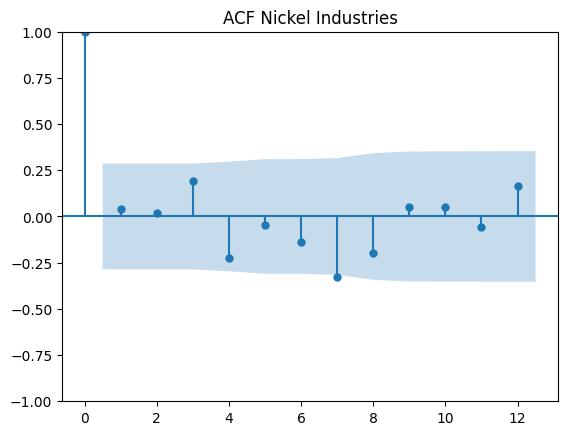

In [36]:
# Autocorrelation of stock price of Nickel Industries
plot_acf(endog_train, lags=12, title="ACF Nickel Industries")
plt.show()

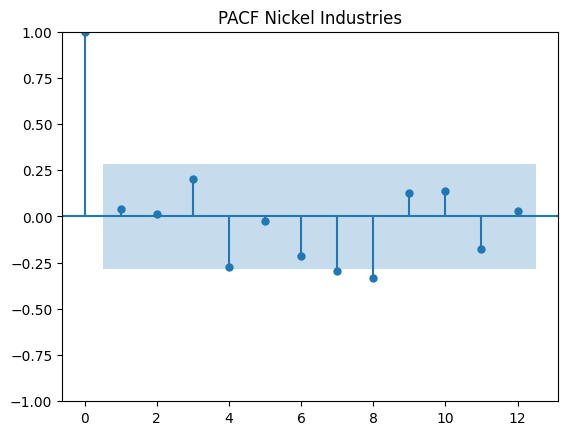

In [37]:
# Partial autocorrelation of stock price of Nickel Industries
plot_pacf(endog_train, lags=12, title="PACF Nickel Industries")
plt.show()

## Augmented Dickey-Fuller test (ADF)

H0: β = 0 (This is a random walk) <br>
H1: β < 0 (This is not a random walk)

In [38]:
# Augmented Dickey-Fuller test on volume/price
adf_price_t = adfuller(endog_train)
print("p-value of test: {}".format(float(adf_price_t[1].round(4))))

p-value of test: 0.0011


#### KPSS test

H0: Stationary <br>
H1: Not Stationary

In [39]:
# KPSS test for stationarity
kpss_test_t = kpss(endog_train)
print("p-value of KPSS: {}".format(float(kpss_test_t[1].round(4))))

p-value of KPSS: 0.1


Now we are ready to apply ARIMA models

# ARIMA

ARIMA models consist of three components: Autoregressive (AR), Integrated (I), and Moving Average (MA). <br>
The (AR) component captures the linear dependence of the time-series on its past values. <br>
The (MA) component captures the linear dependence of the time-series on its past error terms (i.e., residuals). <br>
The (I) component captures the non-stationarity of the time-series by differencing it to make it stationary. <br>

## ARIMA GridSearch

In [40]:
# Tuning hyperparameters
p_params = range(0, 9, 1)
q_params = range(0, 9, 1)
d_params = 0

In [41]:
def ARIMAGridSearch(y_train, p_params, q_params, d_params):
    # Create dictionary to store MAPEs
    mape_grid = dict()
    rmse_grid = dict()
    grid = dict()
    # Outer loop: Iterate through possible values for `p`
    for p in p_params:
        # Create key-value pair in dict. Key is `p`, value is empty list.
        mape_grid[p] = list()
        rmse_grid[p] = list()
        # Inner loop: Iterate through possible values for `q`
        for q in q_params:
            # Combination of hyperparameters for model
            order = (p, d_params, q)
            # Note start time
            start_time = time.time()
            # Train model
            model = ARIMA(y_train, order=order).fit()
            # Generate in-sample (training) predictions
            y_pred = model.predict()
            # Calculate training MAE
            mape = mean_absolute_percentage_error(y_train, y_pred)
            mse = mean_squared_error(y_train, y_pred, squared=False)
            # Calculate model training time
            elapsed_time = round(time.time() - start_time, 2)
            print(f"Trained ARIMA {order} in {elapsed_time} seconds. MAPE is {mape.round(6)}. RMSE is {mse.round(6)}")
            grid[order] = [order, mape.round(6), mse.round(6)]
            # Append MAE to list in dictionary
            mape_grid[p].append(mape)
            rmse_grid[p].append(mse)
            
    
    cols = ['AR' + str(x) for x in p_params]
    index = ['MA' + str(x) for x in q_params]
    grid_arima_mape = pd.DataFrame.from_dict(mape_grid)
    grid_arima_mape.columns = cols
    grid_arima_mape.index = index
    grid_arima_rmse = pd.DataFrame.from_dict(rmse_grid)
    grid_arima_rmse.columns = cols
    grid_arima_rmse.index = index
    
    return grid_arima_mape, grid_arima_rmse, grid


In [42]:
grid_arima_mape, grid_arima_mse, grid = ARIMAGridSearch(endog_train, p_params, q_params, d_params)

Trained ARIMA (0, 0, 0) in 0.03 seconds. MAPE is 2678135689780.199. RMSE is 0.108703
Trained ARIMA (0, 0, 1) in 0.04 seconds. MAPE is 3008091181974.8403. RMSE is 0.108609
Trained ARIMA (0, 0, 2) in 0.06 seconds. MAPE is 2947595151626.063. RMSE is 0.108609
Trained ARIMA (0, 0, 3) in 0.14 seconds. MAPE is 1163397733387.0576. RMSE is 0.101473
Trained ARIMA (0, 0, 4) in 0.16 seconds. MAPE is 3966981645511.9185. RMSE is 0.095464
Trained ARIMA (0, 0, 5) in 0.19 seconds. MAPE is 4266096180991.9023. RMSE is 0.095495
Trained ARIMA (0, 0, 6) in 0.23 seconds. MAPE is 4562189457295.084. RMSE is 0.095462
Trained ARIMA (0, 0, 7) in 0.28 seconds. MAPE is 1441999478168.673. RMSE is 0.089827
Trained ARIMA (0, 0, 8) in 0.34 seconds. MAPE is 495564204210.2036. RMSE is 0.089723
Trained ARIMA (1, 0, 0) in 0.02 seconds. MAPE is 3060593598335.8467. RMSE is 0.108608
Trained ARIMA (1, 0, 1) in 0.03 seconds. MAPE is 3032076384077.279. RMSE is 0.108609
Trained ARIMA (1, 0, 2) in 0.12 seconds. MAPE is 54403727992

In [43]:
pd.DataFrame(grid.values()).head(3)

,0,1,2
0,"(0, 0, 0)",2.678136e+12,0.108703
1,"(0, 0, 1)",3.008091e+12,0.108609
2,"(0, 0, 2)",2.947595e+12,0.108609


Model that better fit the data than other ARIMA (5, 0, 8) with MAPE = 0.094655.<br> But increase in precision isn't realy significant compared to ARIMA (2, 0, 2) with MAPE = 0.099098. <br>
or in comparison with ARIMA (4, 0, 4) with MAPE = 0.095641. <br>
Addition of integration part just worsen the performance, moreover process is already stationary, hence d = 0

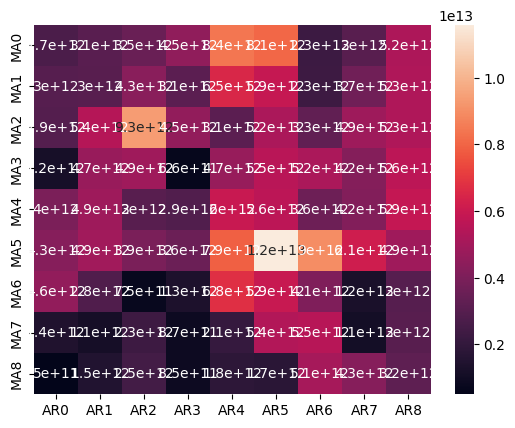

In [44]:
sns.heatmap(grid_arima_mape, annot=True);

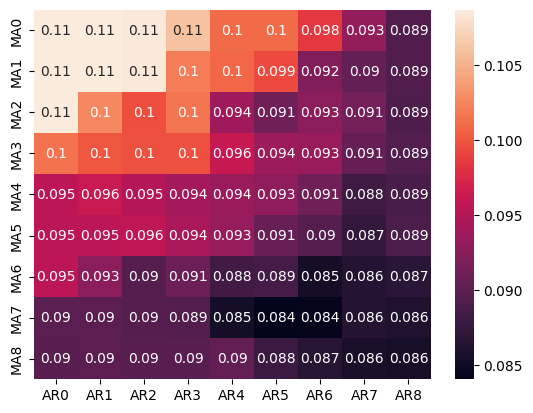

In [45]:
sns.heatmap(grid_arima_mse, annot=True);

## Best ARIMA via GridSearch - order (2, 1, 2)

SARIMAX((p, d, q)(P, D, Q, 12) <br>
p = degree of non-seasonal AR polynomial <br>
P = degree of seasonal AR polynomial <br>
q = degree of non-seasonal MA polynomial <br>
Q = degree of seasonal MA polynomial <br>
d = number of non-seasonal differences to take <br>
D = number of seasonal differences to take <br>
12 = frequency <br>

In [46]:
model_ARIMA_best = ARIMA(order=(2, 0, 2), endog=endog_train, freq='M')
model_ARIMA_best_res = model_ARIMA_best.fit()
model_ARIMA_best_pred = model_ARIMA_best_res.predict()
model_ARIMA_best_fork = model_ARIMA_best_res.predict(start=endog_test.index[0], end=endog_test.index[-1])
#seasonal_order=(0, 1, 0, 12)

In [47]:
Model_4 = pd.Series({
    final_performance_cols[0]: 'Yes - diff(1)',
    final_performance_cols[1]: 'ARIMA(2, 1, 2)_auto',
    final_performance_cols[2]: mean_absolute_percentage_error(endog_train, model_ARIMA_best_pred).round(6),
    final_performance_cols[3]: mean_absolute_percentage_error(endog_test, model_ARIMA_best_fork).round(6),
    final_performance_cols[4]: mean_squared_error(endog_train, model_ARIMA_best_pred, squared=False).round(6),
    final_performance_cols[5]: mean_squared_error(endog_test, model_ARIMA_best_fork, squared=False).round(6)
}).to_frame().T

In [48]:
print(Model_4)
model_ARIMA_best_res.summary()

  Is_y_transformed?                Model            Train_MAPE Test_MAPE  \
0     Yes - diff(1)  ARIMA(2, 1, 2)_auto  9349745669212.759766  4.068482   

  Train_RMSE Test_RMSE  
0   0.099553  0.160363  


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:     Nickel_Industries_Stock_Price   No. Observations:                   47
Model:                            ARIMA(2, 0, 2)   Log Likelihood                  41.119
Date:                           Sun, 26 Mar 2023   AIC                            -70.238
Time:                                   19:41:49   BIC                            -59.137
Sample:                               10-31-2018   HQIC                           -66.061
                                    - 08-31-2022                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0190      0.008      2.423      0.015       0.004       0.034
ar.L1          0.1070      0.235      0.455      0.649      -0.354       0.568
ar.L2          0.5695      0.223      2.556      0.011       0.133       1.006
ma.L1          0.0006   1.46e+04   3.96e-08      1.000   -2.87e+04    2.87e+04
ma.L2         -0.9994   1.46e+04  -6.84e-05      1.000   -2.87e+04    2.87e+04
sigma2         0.0094    136.907   6.84e-05      1.000    -268.324     268.343
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.14
Prob(Q):                              0.94   Prob(JB):                         0.57
Heteroskedasticity (H):               6.04   Skew:                             0.13
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

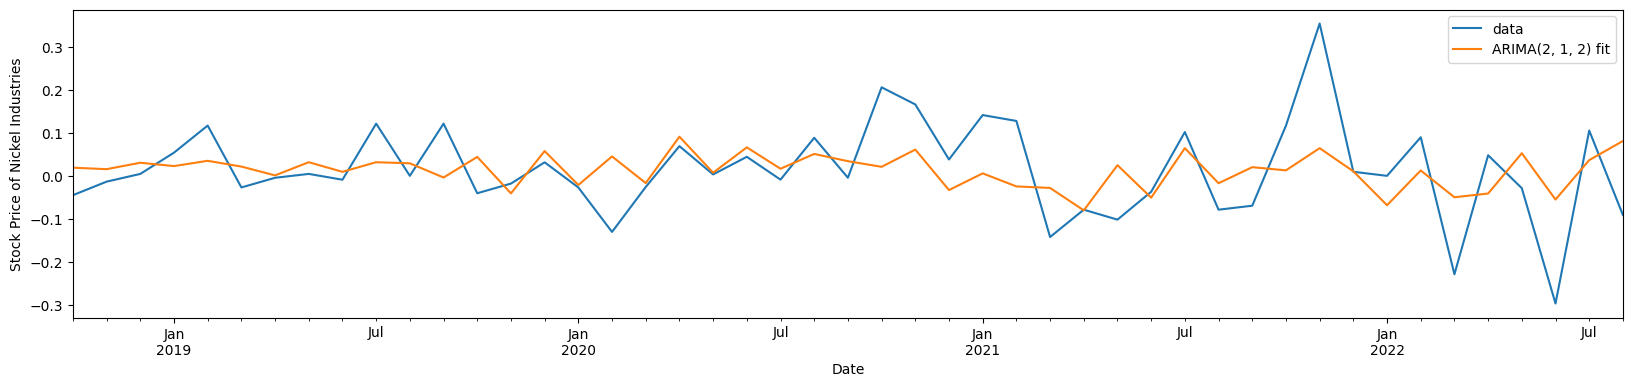

In [49]:
endog_train.plot(label="data", figsize=(20, 4))
model_ARIMA_best_pred.plot(label="ARIMA(2, 1, 2) fit")
plt.ylabel("Stock Price of Nickel Industries")
plt.legend();

## ARIMA (4, 1, 4)

In [56]:
model_ARIMA_4_1_4 = ARIMA(order=(4, 0, 4), endog=endog_train, freq='M')
model_ARIMA_4_1_4_res = model_ARIMA_4_1_4.fit()
model_ARIMA_4_1_4_pred = model_ARIMA_4_1_4_res.predict()
model_ARIMA_4_1_4_fork = model_ARIMA_4_1_4_res.predict(start=endog_test.index[0], end=endog_test.index[-1])

In [57]:
Model_5 = pd.Series({
    final_performance_cols[0]: 'Yes - diff(1)',
    final_performance_cols[1]: 'ARIMA(4, 1, 4)_auto',
    final_performance_cols[2]: mean_absolute_percentage_error(endog_train, model_ARIMA_4_1_4_pred).round(6),
    final_performance_cols[3]: mean_absolute_percentage_error(endog_test, model_ARIMA_4_1_4_fork).round(6),
    final_performance_cols[4]: mean_squared_error(endog_train, model_ARIMA_4_1_4_pred, squared=False).round(6),
    final_performance_cols[5]: mean_squared_error(endog_test, model_ARIMA_4_1_4_fork, squared=False).round(6)
}).to_frame().T

In [58]:
print(Model_5)
model_ARIMA_4_1_4_res.summary()

  Is_y_transformed?                Model            Train_MAPE Test_MAPE  \
0     Yes - diff(1)  ARIMA(4, 1, 4)_auto  5975682911193.769531  6.432699   

  Train_RMSE Test_RMSE  
0   0.093521   0.17225  


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:     Nickel_Industries_Stock_Price   No. Observations:                   47
Model:                            ARIMA(4, 0, 4)   Log Likelihood                  43.947
Date:                           Sun, 26 Mar 2023   AIC                            -67.894
Time:                                   19:44:04   BIC                            -49.393
Sample:                               10-31-2018   HQIC                           -60.932
                                    - 08-31-2022                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0191      0.012      1.609      0.108      -0.004       0.042
ar.L1          0.4335      0.486      0.892      0.373      -0.519       1.386
ar.L2          0.4929      0.466      1.059      0.290      -0.420       1.405
ar.L3          0.1586      0.397      0.400      0.689      -0.619       0.936
ar.L4         -0.7271      0.333     -2.181      0.029      -1.380      -0.074
ma.L1         -0.4057      0.554     -0.732      0.464      -1.491       0.680
ma.L2         -0.6394      0.490     -1.306      0.191      -1.599       0.320
ma.L3          0.1282      0.548      0.234      0.815      -0.946       1.202
ma.L4          0.3265      0.478      0.682      0.495      -0.611       1.264
sigma2         0.0086      0.003      3.293      0.001       0.003       0.014
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):                 9.99
Prob(Q):                              0.72   Prob(JB):                         0.01
Heteroskedasticity (H):               3.84   Skew:                             0.86
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

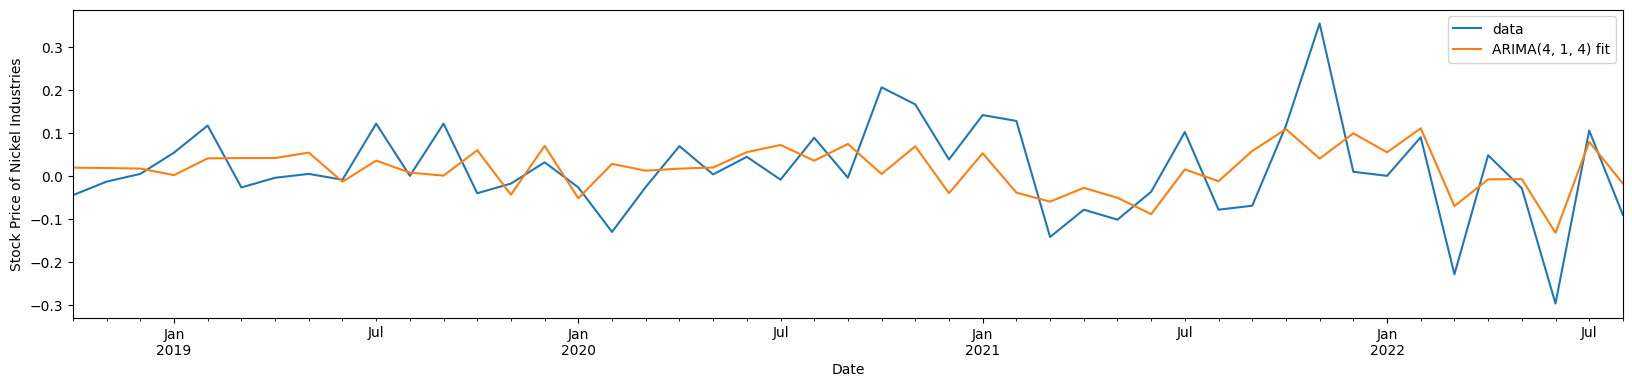

In [59]:
endog_train.plot(label="data", figsize=(20, 4))
model_ARIMA_4_1_4_pred.plot(label="ARIMA(4, 1, 4) fit")
plt.ylabel("Stock Price of Nickel Industries")
plt.legend();

###### ARIMA (6, 0, 7) - CHOOSE MODEL AND MAKE FORMAT

In [51]:
model_ARIMA_6_1_7 = ARIMA(order=(6, 0, 7), endog=endog_train, freq='M')
model_ARIMA_6_1_7_res = model_ARIMA_6_1_7.fit()
model_ARIMA_6_1_7_pred = model_ARIMA_6_1_7_res.predict()
model_ARIMA_6_1_7_fork = model_ARIMA_6_1_7_res.predict(start=endog_test.index[0], end=endog_test.index[-1])

In [52]:
Model_6 = pd.Series({
    final_performance_cols[0]: 'Yes - diff(1)',
    final_performance_cols[1]: 'ARIMA(6, 1, 7)',
    final_performance_cols[2]: mean_absolute_percentage_error(endog_train, model_ARIMA_6_1_7_pred).round(6),
    final_performance_cols[3]: mean_absolute_percentage_error(endog_test, model_ARIMA_6_1_7_fork).round(6),
    final_performance_cols[4]: mean_squared_error(endog_train, model_ARIMA_6_1_7_pred, squared=False).round(6),
    final_performance_cols[5]: mean_squared_error(endog_test, model_ARIMA_6_1_7_fork, squared=False).round(6)
}).to_frame().T

In [53]:
print(Model_6)
model_ARIMA_6_1_7_res.summary()

  Is_y_transformed?           Model           Train_MAPE Test_MAPE Train_RMSE  \
0     Yes - diff(1)  ARIMA(6, 1, 7)  5510554863507.77832  7.168972    0.08432   

  Test_RMSE  
0  0.176021  


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:     Nickel_Industries_Stock_Price   No. Observations:                   47
Model:                            ARIMA(6, 0, 7)   Log Likelihood                  48.034
Date:                           Sun, 26 Mar 2023   AIC                            -66.069
Time:                                   19:43:22   BIC                            -38.317
Sample:                               10-31-2018   HQIC                           -55.626
                                    - 08-31-2022                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0227      0.003      6.628      0.000       0.016       0.029
ar.L1          0.1295      2.249      0.058      0.954      -4.278       4.537
ar.L2          0.3612      1.449      0.249      0.803      -2.479       3.202
ar.L3          0.1931      0.859      0.225      0.822      -1.491       1.877
ar.L4         -0.2140      1.240     -0.173      0.863      -2.643       2.215
ar.L5         -0.6106      1.058     -0.577      0.564      -2.685       1.464
ar.L6          0.0338      1.083      0.031      0.975      -2.089       2.156
ma.L1         -0.1978      3.124     -0.063      0.950      -6.320       5.925
ma.L2         -0.6102      2.782     -0.219      0.826      -6.063       4.843
ma.L3         -0.0281      1.145     -0.025      0.980      -2.273       2.217
ma.L4         -0.1558      1.273     -0.122      0.903      -2.650       2.339
ma.L5          0.7870      0.899      0.875      0.381      -0.976       2.550
ma.L6         -0.1720      2.138     -0.080      0.936      -4.363       4.019
ma.L7         -0.5311      1.793     -0.296      0.767      -4.045       2.983
sigma2         0.0065      0.008      0.840      0.401      -0.009       0.022
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                 6.64
Prob(Q):                              0.85   Prob(JB):                         0.04
Heteroskedasticity (H):               2.97   Skew:                             0.70
Prob(H) (two-sided):                  0.04   Kurtosis:                         4.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

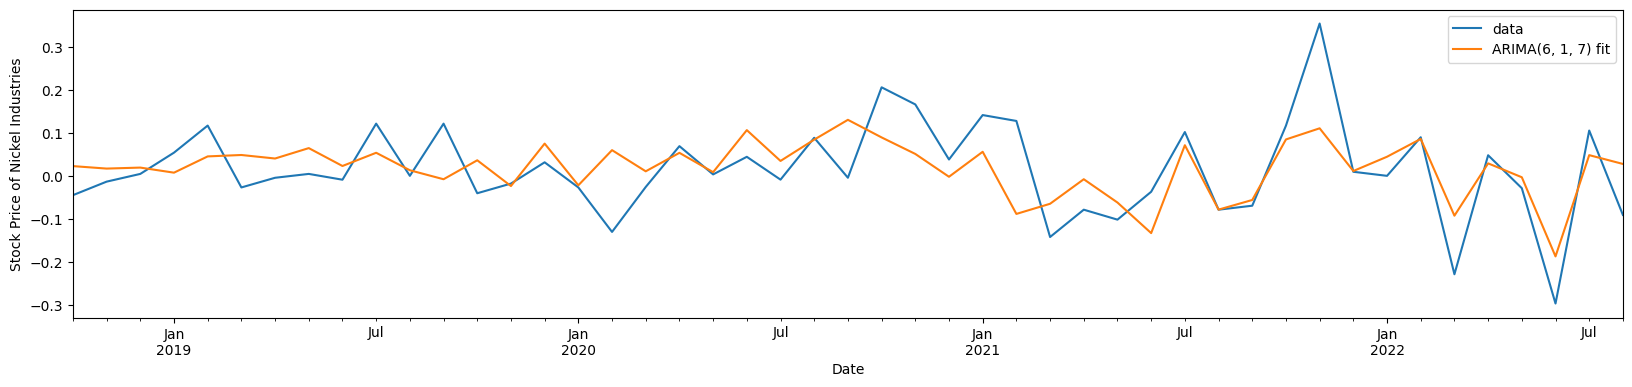

In [55]:
endog_train.plot(label="data", figsize=(20, 4))
model_ARIMA_6_1_7_pred.plot(label="ARIMA(6, 1, 7) fit")
plt.ylabel("Stock Price of Nickel Industries")
plt.legend();

# Model comparison

We choose all best models from each step and try them on test set.

In [60]:
final_results = pd.concat([model_performance, Model_1, Model_2, Model_3, Model_4, Model_5, Model_6], ignore_index=True)
final_results

,Is_y_transformed?,Model,Train_MAPE,Test_MAPE,Train_RMSE,Test_RMSE
0,No,ETS(AAA),0.106932,0.14133,0.10701,0.140038
1,No,ETS(MAN),0.110489,0.163309,0.10797,0.16028
2,No,ETS(MNA)_auto,0.110489,0.120047,0.10797,0.137343
3,Yes - diff(1),"ARIMA(2, 1, 2)_auto",9349745669212.759766,4.068482,0.099553,0.160363
4,Yes - diff(1),"ARIMA(4, 1, 4)_auto",5975682911193.769531,6.432699,0.093521,0.17225
5,Yes - diff(1),"ARIMA(6, 1, 7)",5510554863507.77832,7.168972,0.08432,0.176021


## Currently 
### It is cool that models estimated using AUTO (hence AIC) perform worse on train, but better on test

## ETS_results

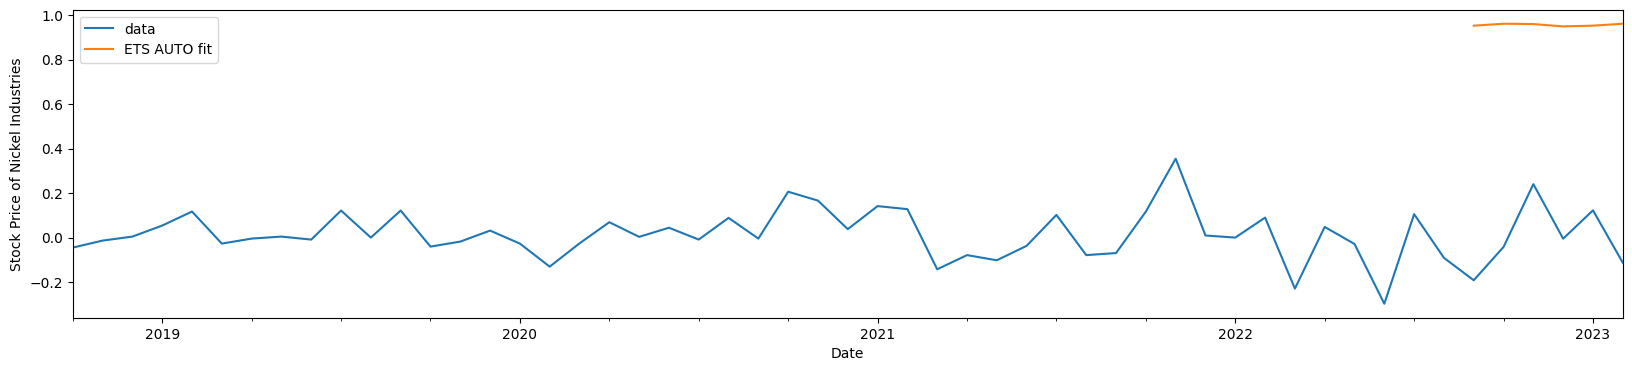

In [61]:
endog_all.plot(label="data", figsize=(20, 4))
ETS_best_res.forecast(len(horizon)).plot(label="ETS AUTO fit")
plt.ylabel("Stock Price of Nickel Industries")
plt.legend();

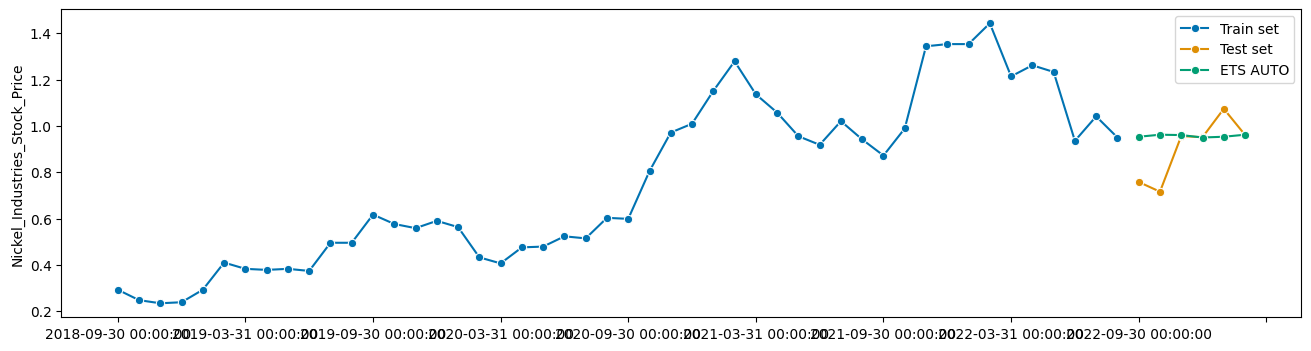

In [62]:
plot_series(endog_train_p, 
            endog_test_p, 
            ETS_best_res.forecast(len(horizon)), 
            labels=['Train set', 'Test set', 'ETS AUTO']);


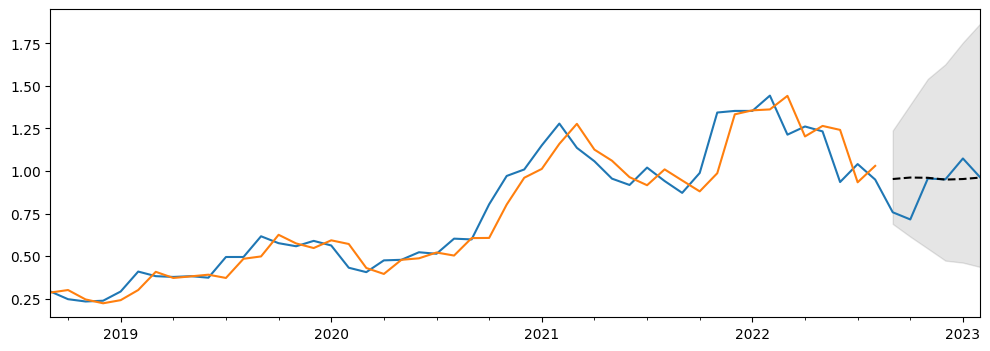

In [63]:
fig, ax = plt.subplots(figsize=(12, 4))

endog.plot(ax=ax)

ETS_best_res.fittedvalues.plot(ax=ax)

predicted_value = ETS_best_res.get_prediction(start=endog_test.index[0], end=endog_test.index[-1]).summary_frame()

predicted_value['mean'].plot(ax=ax, style='k--')
ax.fill_between(predicted_value.index, predicted_value['pi_lower'], predicted_value['pi_upper'], color='k', alpha=0.1);

## ARIMA_results

In [64]:
mean_absolute_percentage_error(endog_test, model_ARIMA_best_res.predict(start=endog_test.index[0], end=endog_test.index[-1])).round(5)

4.06848

In [65]:
model_ARIMA_best_res.predict(start=endog_test.index[0], end=endog_test.index[-1])

2022-09-30   -0.009639
2022-10-31    0.119299
2022-11-30    0.013418
2022-12-31    0.075524
2023-01-31    0.021866
2023-02-28    0.051496
Freq: M, Name: predicted_mean, dtype: float64

In [66]:
model_ARIMA_best_res.get_prediction(start=endog_test.index[0], end=endog_test.index[-1]).summary_frame()

Nickel_Industries_Stock_Price,mean,mean_se,mean_ci_lower,mean_ci_upper
2022-09-30,-0.009639,0.098498,-0.202690,0.183413
2022-10-31,0.119299,0.098984,-0.074705,0.313304
2022-11-30,0.013418,0.105937,-0.194214,0.221050
2022-12-31,0.075524,0.105934,-0.132102,0.283151
2023-01-31,0.021866,0.108053,-0.189914,0.233645
2023-02-28,0.051496,0.108053,-0.160283,0.263276


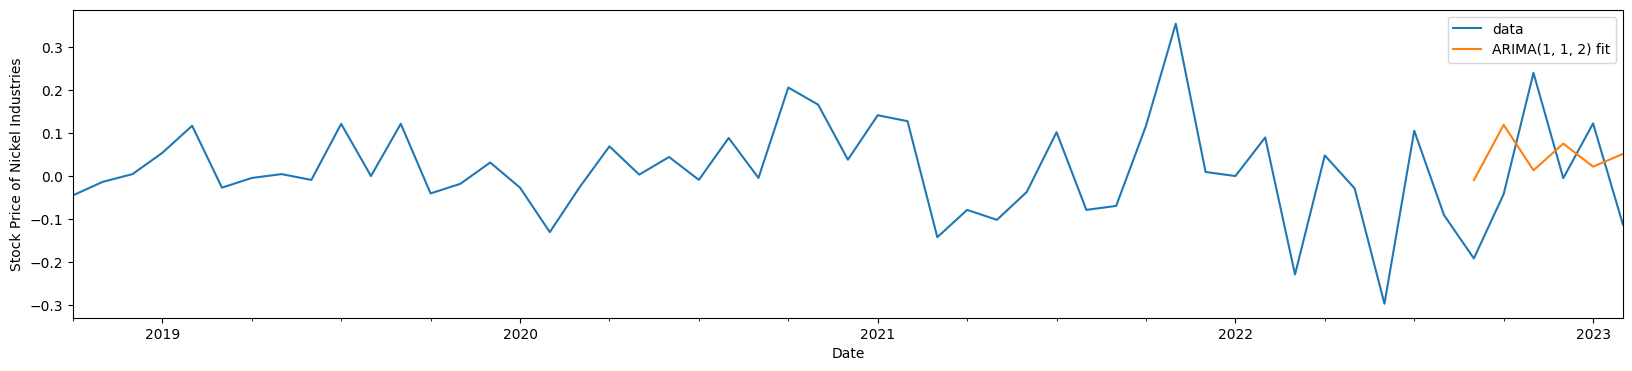

In [67]:
endog_all.plot(label="data", figsize=(20, 4))
model_ARIMA_best_pred = model_ARIMA_best_res.predict(start=endog_test.index[0], end=endog_test.index[-1])


model_ARIMA_best_res.get_prediction(start=endog_test.index[0], end=endog_test.index[-1]).summary_frame()



model_ARIMA_best_pred.plot(label="ARIMA(1, 1, 2) fit")
plt.ylabel("Stock Price of Nickel Industries")
plt.legend();

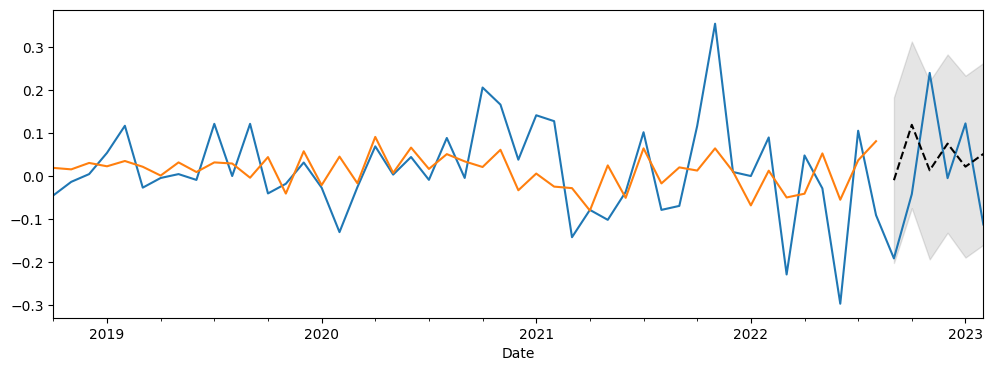

In [68]:
fig, ax = plt.subplots(figsize=(12, 4))

endog_all.plot(ax=ax)

model_ARIMA_best_res.fittedvalues.plot(ax=ax)

predicted_value = model_ARIMA_best_res.get_prediction(start=endog_test.index[0], end=endog_test.index[-1]).summary_frame()

predicted_value['mean'].plot(ax=ax, style='k--')
ax.fill_between(predicted_value.index, predicted_value['mean_ci_lower'], predicted_value['mean_ci_upper'], color='k', alpha=0.1);